In [67]:
import util_match
import pickle
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import os

In [68]:
bool_plot = True   # set to false if just gathering matching data

# Reading data
In case that we get different EoS using the same folder parameters in the future, I'll also keep track of the EoS file. For this I think the file modification time is sufficient.

Unfinished runs are detected by mismatches in the length of beta.

How I treat folder parameters:
* $\mu$, $V$, $t_p$ and $shift$ are things we expect to be different in a folder. All the other parameters should be the same; I include them in `folder_params_shared` and check for every folder.
    * Among them, $\mu$ is additionally saved in `data_in_measurements["mu"]`. I check that this indeed matches the one specified in the folder name.
    * For $V$, $t_p$ and $shift$, I don't do the filtering until all the data are loaded.
* I assume $t = 1$.
* There is also a file with `dBeta' = -dBeta` that goes to negative temperatures. I remove the `beta = 0` row from this one and piece the two files together.

In [167]:
# I had to keep the data files in the download folder, otherwise the folder names are too long
data_folder = Path(r"C:\Users\ken92\Downloads\Shao-Wen Data")
tnpspc = {  # tenpy specs used to generate folder names
    "geometry": "sawtooth",
    "spin": "spinless",     # "spinful", "spinless"
    "interacting": "NI",
    "L": 50,
    "tp": 1.41421356237,
    "shift": -2.0,
    "ymax": None,
    "mumin": -10.0,
    "mumax": 10.0,
    "dMu": 0.01,
    "dBeta": 0.1,           # Use positive here; minus sign added by hand below
    "Nsteps": 200
}
filter_params = {           # Same name as eos_matcher for interacting system so I can borrow code directly, although no filtering is done
    "tp": 1.41421356237,
    "shift": -2.0,
    "ymax": None,
}

Interacting and non-interacting data is stored differently and require different unpacking methods.

In [168]:
# positive beta
scan_name = (f"{tnpspc['geometry']}_{tnpspc['spin']}_NI_L{tnpspc['L']}_t1.0_tp{tnpspc['tp']}_shift{tnpspc['shift']}"
                f"_ymax{tnpspc['ymax']}_mumin{tnpspc['mumin']}_mumax{tnpspc['mumax']}"
                f"_dMu{tnpspc['dMu']}_dBeta{tnpspc['dBeta']}_Nsteps{tnpspc['Nsteps']}.pkl")
filepath = Path(data_folder, scan_name)
assert filepath.is_file()
with open(filepath, "rb") as f:
    file_content = pickle.load(f)

# negative beta
scan_name_neg = (f"{tnpspc['geometry']}_{tnpspc['spin']}_NI_L{tnpspc['L']}_t1.0_tp{tnpspc['tp']}_shift{tnpspc['shift']}"
                f"_ymax{tnpspc['ymax']}_mumin{tnpspc['mumin']}_mumax{tnpspc['mumax']}"
                f"_dMu{tnpspc['dMu']}_dBeta{-tnpspc['dBeta']}_Nsteps{tnpspc['Nsteps']}.pkl")
filepath_neg = Path(data_folder, scan_name_neg)
assert filepath_neg.is_file()
with open(filepath_neg, "rb") as f:
    file_content_neg = pickle.load(f)

## Plots
Even for finite interaction strengths, we still see a trace of the flat band in the $S_{2, avg}$ plot. For example, for the $V = 1$, shift $= 2$ single layer sawtooth, we see an enhancement in entropy around $\mu = 0.5$. I would have naively guessed that this should happen at $\mu = 0.25$ instead by looking at the completely localized states (CLS):
* The wave function of CLS lives on two neighboring teeth, and has values of $1 / \sqrt(2)$ on the shared A site, and $1 / 2$ on the two B sites.
    * i.e. there's half a particle on the A site and a quarter of a particle each on the B sites
* Each of the link then gets an energy of $1/2 \cdot 1/4 \cdot V = 1/8$.
* There are two links, so the shift in energy for each CLS is $1/8 \cdot 2 = 1/4$.

In [169]:
# index is xxx_vals[i_mu, i_beta]
mu_vals = file_content["mus"]
beta_vals_pos = file_content["betas"]
sVN_grid_pos = file_content["data"][:,:,0].T  # Von Neumann entropy per particle
s2_grid_pos = file_content["data"][:,:,1].T   # Renyi 2-entropy per particle
n_grid_pos = file_content["data"][:,:,2].T    # particle per site
e_grid_pos = file_content["data"][:,:,3].T    # energy per particle

assert np.allclose(mu_vals, file_content_neg["mus"])
beta_vals_neg = file_content_neg["betas"]
sVN_grid_neg = file_content_neg["data"][:,:,0].T  # Von Neumann entropy per particle
s2_grid_neg = file_content_neg["data"][:,:,1].T   # Renyi 2-entropy per particle
n_grid_neg = file_content_neg["data"][:,:,2].T    # particle per site
e_grid_neg = file_content_neg["data"][:,:,3].T    # energy per particle

In [170]:
n_grid_neg.shape

(2001, 201)

In [171]:
# sort in increasing beta
beta_vals = np.concatenate([beta_vals_neg[:0:-1], beta_vals_pos])
sVN_grid = np.concatenate([sVN_grid_neg[:,:0:-1], sVN_grid_pos], axis = 1)  # Von Neumann entropy per particle
s2_grid = np.concatenate([s2_grid_neg[:,:0:-1], s2_grid_pos], axis = 1)   # Renyi 2-entropy per particle
n_grid = np.concatenate([n_grid_neg[:,:0:-1], n_grid_pos], axis = 1)    # particle per site
e_grid = np.concatenate([e_grid_neg[:,:0:-1], e_grid_pos], axis = 1)    # energy per particle

L_subregion = tnpspc['L']
N_betas = len(beta_vals)
N_mus = len(mu_vals)

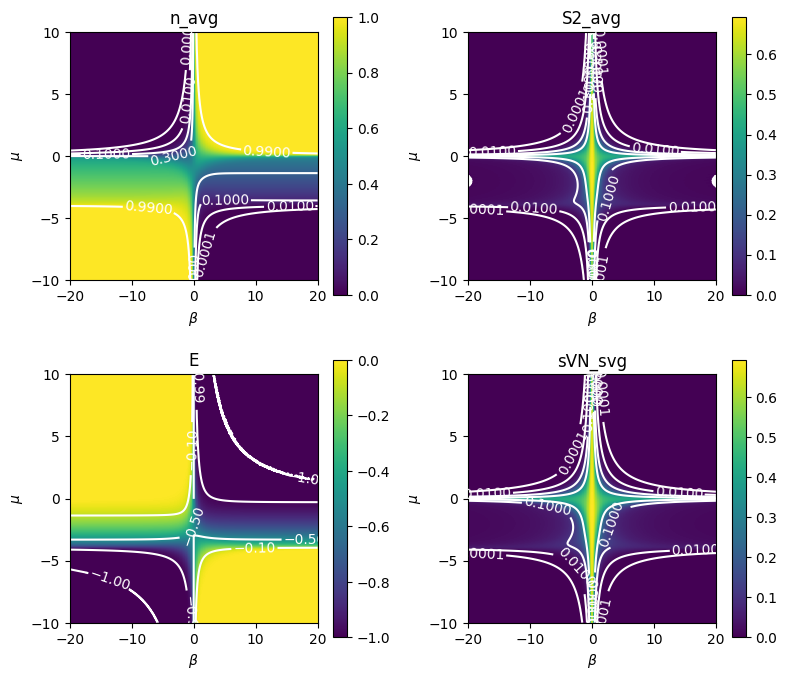

In [172]:
if bool_plot:
    fig_ns, axes_ns = plt.subplots(2, 2, figsize = (8, 7))
    for ax, vals, str_label, clim, levels in zip(axes_ns.flatten(),
                        [n_grid, s2_grid, e_grid, sVN_grid],
                        ["n_avg", "S2_avg", "E", "sVN_svg"],
                        [None, None, None, None],
                        [[1e-4, 1e-2, 0.1, 0.3, 0.99],
                        [1e-4, 1e-2, 0.1, 0.3],
                        [-1, -0.99, -0.5, -0.1],
                        [1e-4, 1e-2, 0.1, 0.3]]):
        img = ax.pcolormesh(beta_vals, mu_vals, vals, clim = clim)
        ax.set_box_aspect(1)
        ax.set_title(str_label)
        ax.set_xlabel(r"$\beta$")
        ax.set_ylabel(r"$\mu$")
        cntr = ax.contour(beta_vals, mu_vals, vals, colors = "white", linestyles = "solid", levels = levels)
        ax.clabel(cntr, inline = True)
        fig_ns.colorbar(img, ax = ax)
    fig_ns.tight_layout()

# Actual calculations
Goal: given our equations of state $n(\mu, \beta)$ and $s_2(\mu, \beta)$, achieve some filling factor $n_s$ in the system for different $(N_{tot}, S_{tot})$
(This also fixes $N_r = N_{tot} - 2 n_s L$, or equivalently $n_r = 2n - n_s$)
1. Find $\mu_{s, r} = \mu(\beta) |_{n(\mu, \beta) = n_{s, r}}$ by inverting $n(\mu, \beta)$. I can do this for all $\beta$.
2. Find $s_2(\mu_{s, r}, \beta)$. As I vary $\beta$ I should get a smooth change in $S_2 = 2 L (s_2(\mu_s) + s_2(\mu_r))$, so the scan in $S_{tot}$ comes for free.
3. Do this for different $N_{tot}$. Now I've in principle done a scan in the $(N, S)$ space.

(Take $L_s = L_r = L$ for now, where $L$ is the number of unit cells, so there are $2L$ sites in each subregion)

Here we get $(n_s; N_{tot}, \beta) \rightarrow (\mu_s, \mu_r, S_{tot})$, where I additionally define
* $V_{offset} = \mu_r - \mu_s$ is the offset potential required to achieve $n_s$.
* $\mu \equiv \mu_r$ --- this one is somewhat arbitrary. Effectively, I'm assuming that $V_{offset}$ is a potential that only increases the potential energy in the system region, while leaving the reservoir region intact. This is the case for our experimental setup, since our DMD light is blue-detuned.
* $n = N_{tot} / 4L$

I write a semicolon for $n_s$ because it is not really a thermodynamic variable in the usual sense, but not including that gives one the wrong impression that the relation is underdetermined. (i.e. I want to have the same number of values on both side)

## $N_{tot}$ and $S_{tot}$ matching
We'll see how well ChatGPT implement this algorithm in 48 seconds.

### Scan $N_{tot}$

In [213]:
# idx_beta_scan = (beta_vals >= 2.)       # Otherwise the contours will be concentrated at small beta where things are boring
idx_beta_scan = (beta_vals >= -100.)      # All beta, use this for the .csv file
beta_scan = beta_vals[idx_beta_scan]
n_s_tar = 0.7   # target filling in the system

N_tot_arr = np.arange((n_s_tar + 0.) * 2 * L_subregion, (n_s_tar + 1) * 2 * L_subregion + 1, dtype=int)

In [214]:
N_s_tar = n_s_tar * L_subregion * 2
assert N_s_tar <= N_tot_arr[-1], f"there must be at least {N_s_tar} particles"

In [215]:
N_beta = beta_scan.size
N_Ntot = N_tot_arr.size

mu_s_all  = np.full((N_Ntot, N_beta), np.nan)
mu_r_all  = np.full((N_Ntot, N_beta), np.nan)
s2_s_all  = np.full((N_Ntot, N_beta), np.nan)
s2_r_all  = np.full((N_Ntot, N_beta), np.nan)
S2_tot_all = np.full((N_Ntot, N_beta), np.nan)
n_r_arr   = np.full(N_Ntot, np.nan)

for k, N_tot in enumerate(N_tot_arr):
    # global filling n and reservoir filling n_r
    n_global = N_tot / (4.0 * L_subregion)
    n_r = 2.0 * n_global - n_s_tar   # equivalently: N_tot/2L - n_s
    n_r_arr[k] = n_r

    # 1) invert n(mu, beta) to get mu_s(beta) and mu_r(beta)
    mu_s = util_match.invert_n_to_mu(mu_vals, beta_scan, n_grid[:, idx_beta_scan], n_s_tar)
    mu_r = util_match.invert_n_to_mu(mu_vals, beta_scan, n_grid[:, idx_beta_scan], n_r)

    mu_s_all[k, :] = mu_s
    mu_r_all[k, :] = mu_r

    # 2) evaluate s2 at those mus
    s2_s = util_match.s2_at_mu(mu_vals, beta_scan, s2_grid[:, idx_beta_scan], mu_s)
    s2_r = util_match.s2_at_mu(mu_vals, beta_scan, s2_grid[:, idx_beta_scan], mu_r)

    s2_s_all[k, :] = s2_s
    s2_r_all[k, :] = s2_r

    # 3) total S2
    S2_tot_all[k, :] = L_subregion * (s2_s + s2_r)

dmu_all = mu_r_all - mu_s_all
mu_glob_all = mu_r_all

In [216]:
for label, data in [("mu_s", mu_s_all), ("mu_r", mu_r_all), ("s2_s", s2_s_all), ("s2_r", s2_r_all)]:
    if np.all(np.isnan(data)):
        raise(ValueError(f"No legal values for {label} within the range of input"))

We are interested in knowing when we can realize $s_r > s_s$. I'll define a dimensionless figure of merit

$\varsigma \equiv s_s / s - 1 = (s_s - s_r) / (s_s + s_r)$ (assume $L_r = L_s$)

that measures the decrease in entropy, measured in entropy per particle if there were no offset. $\varsigma < 0$ indicates cooling effect.

In [217]:
varsigma_all = (s2_s_all - s2_r_all) / (s2_s_all + s2_r_all)
min_varsigma = np.nanmin(varsigma_all.flatten())    # best cooling obtained

# masking arrays derived from varsigma
varsigma_all_nonan = np.nan_to_num(varsigma_all)
mask_alpha_cooling = np.minimum(varsigma_all_nonan, 0.) / min_varsigma

In [218]:
min_varsigma

np.float64(-0.9457752305625423)

### Plots
The amount of cooling is, of course, shaded in red, in each axes. The last axes is a standalone visualization for it that has a fixed color range.
* $s_s$ plot is by definition boring, since $N_{tot}$ doesn't change $n_s$.
* $s_r$ plot has more feature because $n_r$ depends on $N_{tot}$.
* $S_{tot}$
* $\mu$
* $V_{offset}$ tells us the required offset we need to achieve $n_s$ in the system.
* $\varsigma$: the red grids in other axeses are scaled to the maximum amount of cooling. This one always use the same scale for comparison between different input parameters.

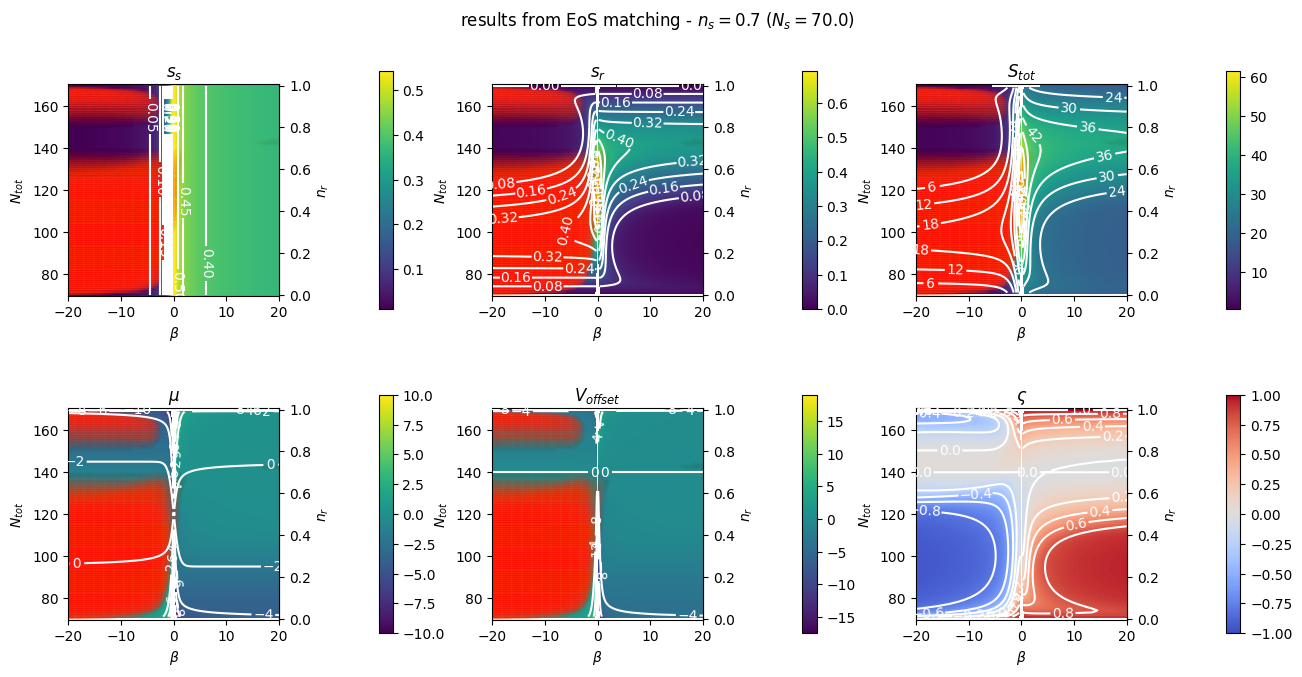

In [219]:
if bool_plot:
    fig_eos, axes_eos_all = plt.subplots(2, 3 * 2, figsize = (13, 7), gridspec_kw = {"width_ratios": [15, 1] * 3})
    axes_eos = axes_eos_all[:, ::2]
    axes_eos_cb = axes_eos_all[:,1::2]
    alpha_cooling_max = 0.3
    for ax, ax_cb, vals, cmap, str_label, clim in zip(axes_eos.flatten(), axes_eos_cb.flatten(),
                        [s2_s_all, s2_r_all, S2_tot_all, mu_glob_all, dmu_all, varsigma_all],
                        ["viridis", "viridis", "viridis", "viridis", "viridis", "coolwarm"],
                        [r"$s_s$", r"$s_r$", r"$S_{tot}$", r"$\mu$", r"$V_{offset}$", r"$\varsigma$"],
                        [None, None, None, None, None, (-1, 1)]):
        img = ax.pcolormesh(beta_scan, N_tot_arr, vals, clim = clim, cmap = cmap)
        ax.set_box_aspect(1)
        ax.set_title(str_label)
        ax.set_xlabel(r"$\beta$")
        ax.set_ylabel(r"$N_{tot}$")
        ryax = ax.secondary_yaxis('right', functions = (lambda x: (x - N_s_tar) / (2 * L_subregion), lambda x: x * 2 * L_subregion + N_s_tar))
        ryax.set_ylabel(r"$n_r$")
        cntr = ax.contour(beta_scan, N_tot_arr, vals, colors = "white", linestyles = "solid", levels = 10)
        ax.clabel(cntr, inline = True)
        fig_eos.colorbar(img, cax = ax_cb, fraction = 0.5, location = 'right')
        # ax_cb.imshow(np.arange(16).reshape(4,4))
        if str_label != r"$\varsigma$":
            ax.pcolormesh(beta_scan, N_tot_arr, np.ones_like(vals), clim = (0, 1), color = "red",# lw = 0.,
                        alpha = mask_alpha_cooling * alpha_cooling_max)
    fig_eos.suptitle(rf"results from EoS matching - $n_s =${n_s_tar} ($N_s =${N_s_tar})")
    fig_eos.tight_layout(w_pad = 0.1)

Now, we scanned $\beta$ because it is easier to do, but we will be more interested in scanning total entropy. This is done in `matching_result_inverter.ipynb`.

### Building the matching results Dataframe

In [220]:
records_matching = []
for i_beta, beta in enumerate(beta_scan):
    for i_Ntot, Ntot in enumerate(N_tot_arr):
        records_matching.append({
            "beta": beta,
            "Ntot": Ntot,
            "n_s": n_s_tar,
            "n_r": n_r_arr[i_Ntot],
            "mu_s": mu_s_all[i_Ntot, i_beta],
            "mu_r": mu_r_all[i_Ntot, i_beta],
            "V_offset": dmu_all[i_Ntot, i_beta],
            "mu_glob": mu_glob_all[i_Ntot, i_beta],
            "s2_s": s2_s_all[i_Ntot, i_beta],
            "s2_r": s2_r_all[i_Ntot, i_beta],
            "S2_tot": S2_tot_all[i_Ntot, i_beta],
            "varsigma": varsigma_all[i_Ntot, i_beta],
            "file_mtime_pos": os.path.getmtime(filepath),
            "file_mtime_neg": os.path.getmtime(filepath_neg),
        } | filter_params)

In [221]:
df_matching_rslt = pd.DataFrame.from_records(records_matching)
# df_matching_rslt

### Save to .csv
I'll treat the following as input parameters:
* All the original folder parameters except for $\mu$.
* $\beta$, $N_{tot}$, $n_s$
* EoS file modification time

A new row of data is added for each input parameters. If an entry with the same input parameters already exists in `csv_path`, we compare if the obtained results agree with the existing ones. If not, we print a warning but leaves the original result unchanged and move on.

Saving everything to a single .csv makes the comparison very slow (several minutes), so I make a new .csv for each $V$, $t_p$, $shift$, and $n_s$. For parameters in the name of .csv, the parameter comparison is done when looking for an existing `csv_path`.

If all the input parameters are the same except for the file modification time, the original entry is replaced if `bool_overwrite_older_mtime = True`, or a new row is added if it is `False`.

In [222]:
raise(Exception("Imma stop here"))  # comment this out to actually save data

Exception: Imma stop here

In [ ]:
input_param_cols = [k for k in filter_params.keys()] + [
    "beta",
    "Ntot",
    "n_s",
    "file_mtime_pos",
    "file_mtime_neg",
]

In [ ]:
def _match_rows(df, row, cols, float_tol=1e-8):
    """Return boolean mask of rows in df that match `row` on all `cols`."""
    if df.empty or len(cols) == 0:
        return np.zeros(len(df), dtype=bool)

    mask = np.ones(len(df), dtype=bool)

    for col in cols:
        val = row[col]
        s = df[col]

        if pd.api.types.is_numeric_dtype(s):
            # numeric comparison with tolerance, NaN == NaN
            if pd.isna(val):
                mask &= s.isna().to_numpy()
            else:
                mask &= np.isclose(
                    s.to_numpy(dtype=float),
                    float(val),
                    atol=float_tol,
                    rtol=0.0,
                    equal_nan=True,
                )
        else:
            # non-numeric: exact match, treating NaN == NaN
            if pd.isna(val):
                mask &= s.isna().to_numpy()
            else:
                mask &= (s == val).to_numpy()

    return mask

def update_eos_csv(
    df_new: pd.DataFrame,
    csv_path: Path,
    param_cols: list,
    bool_overwrite_conflict: bool = False,
    float_tol: float = 1e-8,
):
    """
    Merge df_new into a CSV at csv_path.

    param_cols:
        Columns that define the *input parameters* (including file_mtime).

    Logic per new row:
        - Look for rows in existing CSV with exactly the same param_cols.
        - If none exist: append the new row.
        - If one or more exist:
            * Compare "result columns" (all columns not in param_cols).
            * If any existing row has identical results (within float_tol): do nothing.
            * Otherwise:
                - if bool_overwrite_conflict: replace all matching rows with the new row.
                - else: print a warning, keep existing rows, ignore new row.
    """
    # 1. Load existing CSV, or start from empty
    if os.path.exists(csv_path):
        df_old = pd.read_csv(csv_path)
    else:
        df_old = pd.DataFrame()

    # 2. Align columns between old and new
    all_cols = sorted(set(df_old.columns) | set(df_new.columns))
    df_old = df_old.reindex(columns=all_cols)
    df_new = df_new.reindex(columns=all_cols)

    # "Results" = everything that isn't an input
    result_cols = [c for c in all_cols if c not in param_cols]

    # 3. If no old data, just save and return
    if df_old.empty:
        df_new.to_csv(csv_path, index=False)
        return

    identical_counter = 0
    # 4. Process each new row
    for _, row in df_new.iterrows():
        # rows with the same input parameters (incl. mtime, since it's in param_cols)
        mask_same_inputs = _match_rows(df_old, row, param_cols, float_tol=float_tol)

        if not mask_same_inputs.any():
            df_old = pd.concat([df_old, row.to_frame().T], ignore_index=True)
            continue

        # There are existing rows with identical inputs
        existing_df = df_old.loc[mask_same_inputs]

        # Check if any of them has identical results as well
        mask_identical_results = _match_rows(
            existing_df, row, result_cols, float_tol=float_tol
        )
        if mask_identical_results.any():
            identical_counter += 1
            continue

        # If we get here: same inputs, but *no* row with same results => conflict
        print(
            "WARNING: conflicting results for identical input parameters; "
            f"Ntot={row.get('Ntot')}, beta={row.get('beta')}, n_s={row.get('n_s')},"
            f"mtime_pos={row.get('file_mtime_pos')}, mtime_neg={row.get('file_mtime_neg')}"
        )

        if bool_overwrite_conflict:
            df_old = df_old.drop(existing_df.index)
            df_old = pd.concat([df_old, row.to_frame().T], ignore_index=True)
        else:
            pass

    if identical_counter > 0:
        print(f"{identical_counter} rows already existed in .csv")
    df_old.to_csv(csv_path, index=False)

Check the number of rows existed in .csv if this is something I've run before.

In [ ]:
matching_results_folder = Path(r"C:\Users\ken92\Documents\Studies\E5\simulation\E9_simulations\projects\flat_band_cooling\tenpy_results\matching_results",
                               f"{tnpspc['geometry']}_{tnpspc['spin']}_NI_L{tnpspc['L']}")
matching_results_folder.mkdir(exist_ok = True)
csv_name = f"tp{filter_params['tp']}_shift{filter_params['shift']}_ns{n_s_tar}.csv"
csv_path = Path(matching_results_folder, csv_name)

update_eos_csv(
    df_new = df_matching_rslt,
    csv_path = csv_path,
    param_cols = input_param_cols,
    bool_overwrite_conflict = True,
)